The vanishing gradient problem: cumulative back-propagated error signals either shrink rapidly, or grow out of bounds. They decay exponentially in the number of layers, or they explode. The result is that the final trained network converges to a poor local minimum.

Activation (non-linear) functions that do not saturate:

   Rectifier Linear Unit, ReLU: $y=max(0,x)$, $y \in [0,\infty]$, learning rate $\alpha \rightarrow 0$

Leaky ReLU: $y=max(s·x,x)$ , typically $s=0.01$

Exponential Linear Unit, ELU: $y=s(e^{x}-1$), usually $s=1$. if $s=1$, then $y \in [-1,\infty]$ 

# Reading data

Same function as previous examples:

In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from sklearn.preprocessing import OneHotEncoder
from time import time
import datetime

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
file_name = "notMNIST.pickle"
def make_datasets (file, n_training_samples=0, n_dev_samples=0, 
                   n_testing_samples=0, one_hot=False):
    with open (file,'rb') as f:
        dataset = pickle.load(f)
        f.close

    train_dataset = dataset['train_dataset']
    train_labels = dataset['train_labels']
    dev_dataset = dataset['valid_dataset']
    dev_labels = dataset['valid_labels']
    test_dataset = dataset['test_dataset']
    test_labels = dataset['test_labels']

    #Prepare training, dev (validation) and final testing data. 
    #It has to be reshaped since (n_samples, n_fatures) are expected

    all_training_samples, width, height = train_dataset.shape
    train_attributes = np.reshape(train_dataset, (all_training_samples, 
                                                  width * height))
    if (n_training_samples != 0):
        train_attributes = train_attributes[0:n_training_samples]
        train_labels = train_labels[0:n_training_samples]

    all_dev_samples, width, height = dev_dataset.shape
    dev_attributes = np.reshape(dev_dataset,
                                       (all_dev_samples, width * height))
    if (n_dev_samples != 0):
        dev_attributes = dev_attributes[0:n_dev_samples]
        dev_labels = dev_labels[0:n_dev_samples]

    all_testing_samples, width, height = test_dataset.shape
    test_attributes = np.reshape(test_dataset, (all_testing_samples, width * height))
    if (n_testing_samples != 0):
        test_attributes = test_attributes[0:n_testing_samples]
        test_labels = test_labels[0:n_testing_samples]

    # If one-hot encoding is requested, then funtion OneHotEcoding 
    # from SciKit-Learn is called    
    if one_hot:
        enc = OneHotEncoder(sparse=False)
        # Labels are one-dimensional vectors, 
        # and are reshaped to matrices of one column
        train_labels = enc.fit_transform(train_labels.reshape(len(train_labels),1))
        dev_labels = enc.fit_transform(dev_labels.reshape(len(dev_labels), 1))
        test_labels = enc.fit_transform(test_labels.reshape(len(test_labels), 1))

    return (train_attributes, train_labels, dev_attributes, 
            dev_labels, test_attributes, test_labels)

In [4]:
#EDITED TO REFLECT THE ASSIGNMENT SPECS
NUM_TRAINING_SAMPLES = 10000
NUM_DEV_SAMPLES = 1000
NUM_TESTING_SAMPLES = 1000 #In the locker

In [5]:
x_train, y_train, x_dev, y_dev, x_test, y_test = make_datasets(file_name, 
                                 n_training_samples=NUM_TRAINING_SAMPLES,
                                 n_dev_samples=NUM_DEV_SAMPLES, 
                                 n_testing_samples=NUM_TESTING_SAMPLES,
                                 one_hot=True)

# Building the 28x28-300-200-100-10 deep neural network

Hyper-paramenters configuration:

In [6]:
n_epochs = 10000
epochs_to_display = 200
batch_size = 200 #400
learning_rate = 0.01

TOT_EPOCS=10000

n_inputs = len(x_train[0])
n_hidden1 = 300
n_hidden2 = 200
n_hidden3 = 100
n_outputs = len(y_train[0])

First, the input __X__ and target __t__ matrices are defined as placeholders:

In [7]:
with tf.name_scope("io"):
    X = tf.placeholder(dtype=tf.float32, shape=(None,n_inputs), name="X")
    t = tf.placeholder(dtype=tf.float32, shape=(None,n_outputs), name="t")

Then, the neural network topology is defined: A full-connected 28x28-300-200-100-10 deep neural network. Note that ReLU is the activation function for the hidden layers, and linear logits with softmax for the output. net_out represents the logits of the output layer.

In [8]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    net_out = tf.layers.dense(hidden3, n_outputs, name="net_out")
    y = tf.nn.softmax(logits=net_out, name="y")
    rounded_y = tf.round(y)

# Loss and cost functions with cross entropy and log-loss

In [10]:
with tf.name_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=t, logits=net_out)
    mean_log_loss = tf.reduce_mean(cross_entropy, name="mean_loss")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



# Evaluating the model

In [10]:
correct_predictions = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions,tf.float32))

# Defining the learning algorithm: gradient descent with back-prop

In [10]:
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(mean_log_loss)

# Modifications

## Optimization Algorithms

First question we should ask ourself, is the bias low-enough?
Right now the difference between train error and human error (supposed to be 0 in this example) is roughly 3%. We have no measure to define if this is low or high given that we have no definitive threshold.

What we can do is trying to change optimization method in order to lower the number of epocs needed for the full training. We think that doing this now will give us more chances to try different strategies for variance reduction.

We will accept another optimization method only if it will keep or improve the actual bias. In case of ties, we will pick the one with best variabilty and/or the most simple one.

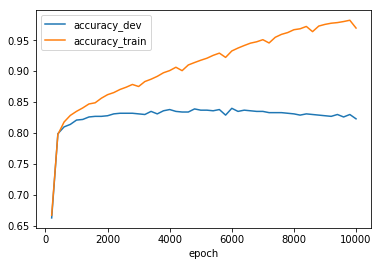

In [39]:
baseline_results.plot()

it is quite clear that the slope of the train accuracy if far from "nice". Also we already witnessthe dev accuracy to increase, thus signaling overfitting. Notes the spikes, very strange...

### Exponential Decay

In [17]:
initial_learning_rate = 0.1
decay_steps = 10000
decay_rate = 0.96
global_step = tf.Variable(0, trainable=False, name="global_step")
learning_rate = tf.train.exponential_decay(initial_learning_rate,
global_step, decay_steps,
decay_rate)
optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
train_step = optimizer.minimize(mean_log_loss, global_step=global_step)


In [18]:
exp_decay_results, run_time = run(TOT_EPOCS)

200 Train accuracy:  0.7092 Development accuracy:  0.7
400 Train accuracy:  0.8973 Development accuracy:  0.836
600 Train accuracy:  0.9369 Development accuracy:  0.832
800 Train accuracy:  0.9575 Development accuracy:  0.832
1000 Train accuracy:  0.9747 Development accuracy:  0.839
1200 Train accuracy:  0.9878 Development accuracy:  0.838
1400 Train accuracy:  0.9792 Development accuracy:  0.836
1600 Train accuracy:  0.9842 Development accuracy:  0.832
1800 Train accuracy:  0.9893 Development accuracy:  0.845
2000 Train accuracy:  0.9899 Development accuracy:  0.832
2200 Train accuracy:  0.9928 Development accuracy:  0.845
2400 Train accuracy:  0.9947 Development accuracy:  0.843
2600 Train accuracy:  0.9945 Development accuracy:  0.836
2800 Train accuracy:  0.9904 Development accuracy:  0.834
3000 Train accuracy:  0.9921 Development accuracy:  0.836
3200 Train accuracy:  0.9911 Development accuracy:  0.828
3400 Train accuracy:  0.9947 Development accuracy:  0.84
3600 Train accuracy: 

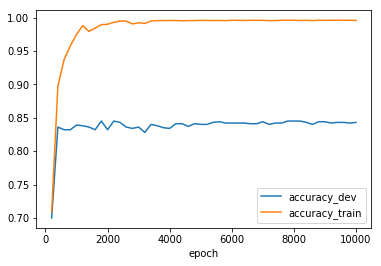

In [41]:
exp_decay_results.plot()

In [20]:
exp_decay_results.iloc[-1]

accuracy_dev      0.8430
accuracy_train    0.9956
Name: 10000, dtype: float64

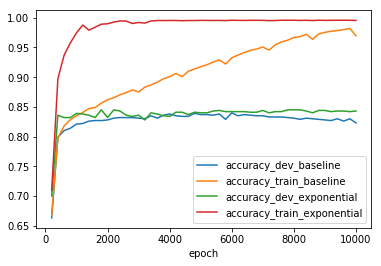

In [44]:
baseline_results.join(exp_decay_results, lsuffix='_baseline', rsuffix='_exponential').plot()

So we reduced sensibly the bias without impacting the variance. From the data we can see that we can reduce the number of epocs to 5k, thus gaining 50% of the time.

### Momentum 

In [23]:
optimizer = tf.train.MomentumOptimizer(learning_rate=0.1, momentum=0.9)
train_step = optimizer.minimize(mean_log_loss, global_step=global_step)

In [27]:
momentum_results, momentum_time = run(TOT_EPOCS)

200 Train accuracy:  0.7194 Development accuracy:  0.712
400 Train accuracy:  0.8936 Development accuracy:  0.842
600 Train accuracy:  0.933 Development accuracy:  0.823
800 Train accuracy:  0.954 Development accuracy:  0.842
1000 Train accuracy:  0.9763 Development accuracy:  0.852
1200 Train accuracy:  0.9857 Development accuracy:  0.849
1400 Train accuracy:  0.9858 Development accuracy:  0.846
1600 Train accuracy:  0.9842 Development accuracy:  0.845
1800 Train accuracy:  0.9858 Development accuracy:  0.847
2000 Train accuracy:  0.9898 Development accuracy:  0.851
2200 Train accuracy:  0.9924 Development accuracy:  0.852
2400 Train accuracy:  0.99 Development accuracy:  0.854
2600 Train accuracy:  0.9947 Development accuracy:  0.862
2800 Train accuracy:  0.9939 Development accuracy:  0.852
3000 Train accuracy:  0.9943 Development accuracy:  0.855
3200 Train accuracy:  0.995 Development accuracy:  0.856
3400 Train accuracy:  0.9921 Development accuracy:  0.847
3600 Train accuracy:  0

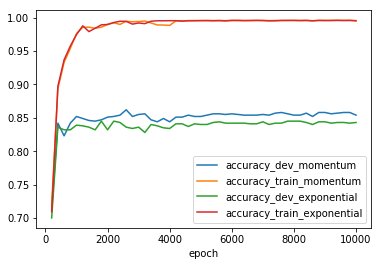

In [30]:
momentum_results.join(exp_decay_results, lsuffix='_momentum', rsuffix='_exponential').plot()

So, same execution time, same number of iterations to reach stability, but better variance. Fot this reason momentum appears to be better

### Nesterov accellerated gradient

In [31]:
optimizer = tf.train.MomentumOptimizer(learning_rate=0.1, momentum=0.9,
use_nesterov=True)
train_step = optimizer.minimize(mean_log_loss, global_step=global_step)

In [32]:
nesterov_results, nesterov_time = run(TOT_EPOCS)

200 Train accuracy:  0.72 Development accuracy:  0.711
400 Train accuracy:  0.9071 Development accuracy:  0.826
600 Train accuracy:  0.9543 Development accuracy:  0.826
800 Train accuracy:  0.9627 Development accuracy:  0.82
1000 Train accuracy:  0.9777 Development accuracy:  0.824
1200 Train accuracy:  0.9871 Development accuracy:  0.839
1400 Train accuracy:  0.9909 Development accuracy:  0.827
1600 Train accuracy:  0.9905 Development accuracy:  0.839
1800 Train accuracy:  0.9925 Development accuracy:  0.851
2000 Train accuracy:  0.9894 Development accuracy:  0.84
2200 Train accuracy:  0.9925 Development accuracy:  0.843
2400 Train accuracy:  0.9931 Development accuracy:  0.835
2600 Train accuracy:  0.9936 Development accuracy:  0.837
2800 Train accuracy:  0.9953 Development accuracy:  0.856
3000 Train accuracy:  0.9948 Development accuracy:  0.85
3200 Train accuracy:  0.9955 Development accuracy:  0.847
3400 Train accuracy:  0.9957 Development accuracy:  0.848
3600 Train accuracy:  0

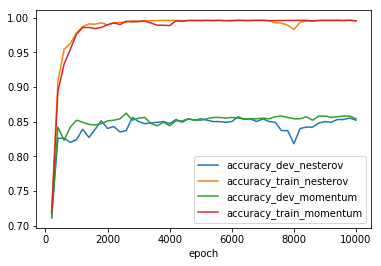

In [34]:
nesterov_results.join(momentum_results, lsuffix="_nesterov", rsuffix="_momentum").plot()

nestorev does not seem to be a noticeable improvement, we are going to keep momentum, given that it is simpler

### Adam

In [35]:
optimizer = tf.train.AdamOptimizer(learning_rate= 0.001)
train_step = optimizer.minimize(mean_log_loss, global_step=global_step)


In [36]:
adam_results, adam_time = run(TOT_EPOCS)

200 Train accuracy:  0.713 Development accuracy:  0.718
400 Train accuracy:  0.9143 Development accuracy:  0.839
600 Train accuracy:  0.9677 Development accuracy:  0.845
800 Train accuracy:  0.9746 Development accuracy:  0.841
1000 Train accuracy:  0.9891 Development accuracy:  0.844
1200 Train accuracy:  0.9915 Development accuracy:  0.833
1400 Train accuracy:  0.9892 Development accuracy:  0.837
1600 Train accuracy:  0.9929 Development accuracy:  0.843
1800 Train accuracy:  0.9895 Development accuracy:  0.836
2000 Train accuracy:  0.9934 Development accuracy:  0.832
2200 Train accuracy:  0.9937 Development accuracy:  0.839
2400 Train accuracy:  0.988 Development accuracy:  0.82
2600 Train accuracy:  0.9911 Development accuracy:  0.829
2800 Train accuracy:  0.9933 Development accuracy:  0.842
3000 Train accuracy:  0.9945 Development accuracy:  0.851
3200 Train accuracy:  0.9844 Development accuracy:  0.841
3400 Train accuracy:  0.9917 Development accuracy:  0.835
3600 Train accuracy: 

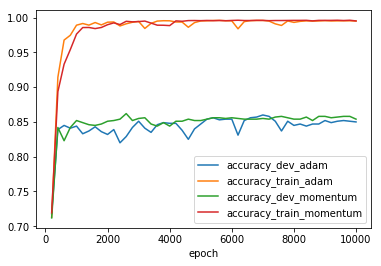

In [37]:
adam_results.join(momentum_results, lsuffix="_adam", rsuffix="_momentum").plot()

Adam is faster as prmosed in reaching the maximum train accuracy, but the dev and train accuracy have periodic spikes.

The gain is not worth it. We will stick with momentum

# Next Step: change learning rate

In [47]:
optimizer = tf.train.MomentumOptimizer(learning_rate=0.01, momentum=0.9)
train_step = optimizer.minimize(mean_log_loss, global_step=global_step)

momentum_1_results, _ = run(5000)

200 Train accuracy:  0.7221 Development accuracy:  0.717
400 Train accuracy:  0.8638 Development accuracy:  0.82
600 Train accuracy:  0.8993 Development accuracy:  0.828
800 Train accuracy:  0.9252 Development accuracy:  0.838
1000 Train accuracy:  0.9574 Development accuracy:  0.836
1200 Train accuracy:  0.9743 Development accuracy:  0.834
1400 Train accuracy:  0.9849 Development accuracy:  0.829
1600 Train accuracy:  0.9744 Development accuracy:  0.829
1800 Train accuracy:  0.9919 Development accuracy:  0.835
2000 Train accuracy:  0.9932 Development accuracy:  0.835
2200 Train accuracy:  0.9936 Development accuracy:  0.83
2400 Train accuracy:  0.9945 Development accuracy:  0.838
2600 Train accuracy:  0.9947 Development accuracy:  0.834
2800 Train accuracy:  0.9947 Development accuracy:  0.836
3000 Train accuracy:  0.9941 Development accuracy:  0.828
3200 Train accuracy:  0.9936 Development accuracy:  0.827
3400 Train accuracy:  0.9949 Development accuracy:  0.836
3600 Train accuracy:

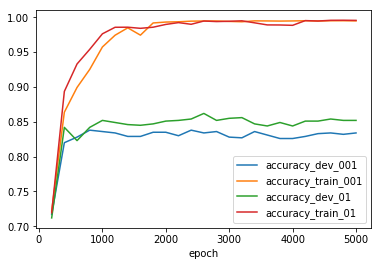

In [50]:
momentum_1_results.join(momentum_results, lsuffix="_001", rsuffix="_01").plot()

It is better with 0.1

# Final setup for optimizer

In [12]:
global_step = tf.Variable(0, trainable=False, name="global_step")
optimizer = tf.train.MomentumOptimizer(learning_rate=0.1, momentum=0.9)
train_step = optimizer.minimize(mean_log_loss, global_step=global_step)
TOT_EPOCS = 5000

We also set the epochs to 5k

In [19]:
momentum_results, _ = run(TOT_EPOCS)

200 Train accuracy:  0.7083 Development accuracy:  0.702
400 Train accuracy:  0.8852 Development accuracy:  0.836
600 Train accuracy:  0.9318 Development accuracy:  0.843
800 Train accuracy:  0.9333 Development accuracy:  0.821
1000 Train accuracy:  0.9643 Development accuracy:  0.834
1200 Train accuracy:  0.9714 Development accuracy:  0.832
1400 Train accuracy:  0.9841 Development accuracy:  0.837


KeyboardInterrupt: 

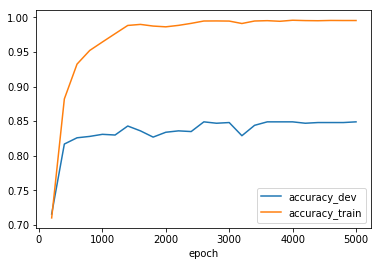

In [25]:
momentum_results.plot()

In [26]:
pd.to_pickle(momentum_results, "momentum_results.pickle")

In [13]:
momentum_results = pd.read_pickle("momentum_results.pickle")

## Next step: weight initialization
Weight initialization should affect mainly the training time and bias, hence we should try it now, before getting to the variance.

In [15]:
#set the reandom seed to have always the same results
tf.set_random_seed(1234)

In [9]:
with tf.name_scope("dnn"):
    he_init = tf.contrib.layers.variance_scaling_initializer()
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1", kernel_initializer=he_init)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2", kernel_initializer=he_init)
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3", kernel_initializer=he_init)
    net_out = tf.layers.dense(hidden3, n_outputs, name="net_out", kernel_initializer=he_init)
    y = tf.nn.softmax(logits=net_out, name="y")
    rounded_y = tf.round(y)

Instructions for updating:
Use the retry module or similar alternatives.


In [19]:
he_init_results, he_init_time = run(TOT_EPOCS)

200 Train accuracy:  0.7225 Development accuracy:  0.736
400 Train accuracy:  0.8949 Development accuracy:  0.825
600 Train accuracy:  0.9347 Development accuracy:  0.816
800 Train accuracy:  0.9502 Development accuracy:  0.824
1000 Train accuracy:  0.9693 Development accuracy:  0.821
1200 Train accuracy:  0.9831 Development accuracy:  0.824
1400 Train accuracy:  0.9842 Development accuracy:  0.832
1600 Train accuracy:  0.9855 Development accuracy:  0.835
1800 Train accuracy:  0.9895 Development accuracy:  0.832
2000 Train accuracy:  0.9859 Development accuracy:  0.834
2200 Train accuracy:  0.9891 Development accuracy:  0.834
2400 Train accuracy:  0.993 Development accuracy:  0.827
2600 Train accuracy:  0.9904 Development accuracy:  0.831
2800 Train accuracy:  0.9931 Development accuracy:  0.837
3000 Train accuracy:  0.9938 Development accuracy:  0.832
3200 Train accuracy:  0.994 Development accuracy:  0.826
3400 Train accuracy:  0.9902 Development accuracy:  0.832
3600 Train accuracy:

There is no visible improvement in random weight initialization, neither for bias or variance

## Next step: pick an activation function and stick with it

It may be interesting to try with different activation functions for the hidden layers

### elu

In [9]:
with tf.name_scope("dnn"):
    acti_fun = tf.nn.elu
    hidden1 = tf.layers.dense(X, n_hidden1, activation=acti_fun, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=acti_fun, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=acti_fun, name="hidden3")
    net_out = tf.layers.dense(hidden3, n_outputs, name="net_out")
    y = tf.nn.softmax(logits=net_out, name="y")
    rounded_y = tf.round(y)

In [20]:
elu_results, _ = run(TOT_EPOCS,  save_to = "elu_results.pickle")

200 Train accuracy:  0.7097 Development accuracy:  0.711
400 Train accuracy:  0.8892 Development accuracy:  0.825
600 Train accuracy:  0.9304 Development accuracy:  0.84
800 Train accuracy:  0.9486 Development accuracy:  0.834
1000 Train accuracy:  0.9801 Development accuracy:  0.837
1200 Train accuracy:  0.9823 Development accuracy:  0.823
1400 Train accuracy:  0.9889 Development accuracy:  0.834
1600 Train accuracy:  0.9912 Development accuracy:  0.838
1800 Train accuracy:  0.9845 Development accuracy:  0.832
2000 Train accuracy:  0.9845 Development accuracy:  0.83
2200 Train accuracy:  0.9856 Development accuracy:  0.82
2400 Train accuracy:  0.9793 Development accuracy:  0.84
2600 Train accuracy:  0.9887 Development accuracy:  0.84
2800 Train accuracy:  0.9942 Development accuracy:  0.849
3000 Train accuracy:  0.9937 Development accuracy:  0.843
3200 Train accuracy:  0.986 Development accuracy:  0.839
3400 Train accuracy:  0.9913 Development accuracy:  0.836
3600 Train accuracy:  0.

In [22]:
elu_results.to_pickle("elu_results.pickle")

In [23]:
elu_results = pd.read_pickle("elu_results.pickle")

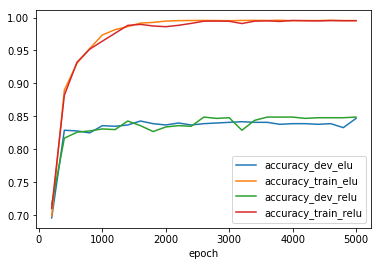

In [19]:
elu_results.join(momentum_results, lsuffix="_elu", rsuffix="_relu").plot()

elu curve is a little bit smoother

### Leaky relu

In [8]:
with tf.name_scope("dnn"):
    acti_fun = tf.nn.leaky_relu
    hidden1 = tf.layers.dense(X, n_hidden1, activation=acti_fun, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=acti_fun, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=acti_fun, name="hidden3")
    net_out = tf.layers.dense(hidden3, n_outputs, name="net_out")
    y = tf.nn.softmax(logits=net_out, name="y")
    rounded_y = tf.round(y)

In [15]:
leaky_relu_results, _ = run(TOT_EPOCS)

200 Train accuracy:  0.7131 Development accuracy:  0.709
400 Train accuracy:  0.8876 Development accuracy:  0.826
600 Train accuracy:  0.9369 Development accuracy:  0.838
800 Train accuracy:  0.9448 Development accuracy:  0.816
1000 Train accuracy:  0.9685 Development accuracy:  0.826
1200 Train accuracy:  0.9762 Development accuracy:  0.829
1400 Train accuracy:  0.9859 Development accuracy:  0.823
1600 Train accuracy:  0.9874 Development accuracy:  0.832
1800 Train accuracy:  0.9883 Development accuracy:  0.834
2000 Train accuracy:  0.981 Development accuracy:  0.827
2200 Train accuracy:  0.9847 Development accuracy:  0.825
2400 Train accuracy:  0.9831 Development accuracy:  0.828
2600 Train accuracy:  0.9926 Development accuracy:  0.827
2800 Train accuracy:  0.9948 Development accuracy:  0.843
3000 Train accuracy:  0.9952 Development accuracy:  0.847
3200 Train accuracy:  0.9953 Development accuracy:  0.845
3400 Train accuracy:  0.9951 Development accuracy:  0.845
3600 Train accuracy

In [18]:
pd.to_pickle(leaky_relu_results, "leaky_relu_results.pickle")

In [ ]:
leaky_relu_results = pd.read_pickle("leaky_relu_results.pickle")

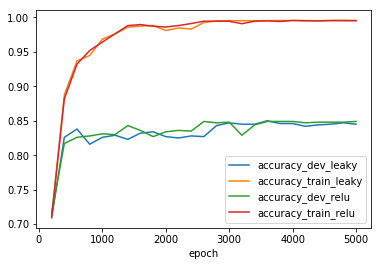

In [23]:
leaky_relu_results.iloc[:25].join(momentum_results, lsuffix="_leaky", rsuffix="_relu").plot()

### Activation function result
we prefer to use elu as the curves appears to be smoother.

In [8]:
with tf.name_scope("dnn"):
    acti_fun = tf.nn.elu
    hidden1 = tf.layers.dense(X, n_hidden1, activation=acti_fun, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=acti_fun, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=acti_fun, name="hidden3")
    net_out = tf.layers.dense(hidden3, n_outputs, name="net_out")
    y = tf.nn.softmax(logits=net_out, name="y")
    rounded_y = tf.round(y)

In [26]:
elu_results.iloc[-1]

accuracy_dev      0.8380
accuracy_train    0.9853
Name: 5000, dtype: float64

## Next step: batch normalization seems really cool

Batch normalization is used to speed the training, hence impacts the bias. We are satisfied with the current result and we think that the training right now is fast enough. We will use batch normalization in case further modifications will require speeding more the training process.

# Bias reduction results
We tackled the bias reduction problem with the goal of also reducing the training time, (reducing the epocs needed to obtain a stable result). We went from 97.1% train accuracy to 99.8%, thus reducing the bias to 0.5%, while keeping the dev accuracy to 83.8%. We also reduced the number of epochs needed to train fro 10lk to 5k, effectively cutting by a half the training time.
The final setup is to use the momentum optimizer, with 0.1 learning rate and momentum coefficient to 0.9, and elu activation functions in all the hidden layers. Random weights initialization has shown no sensible improvement, and we also decided to discard batch normalization.

We are now in the following overfitting situation of low bias and high variance: 0.5% bias, 17% variance.

# Variance Reduction

The idea is to start with L2 regularition as it appears to be the simpler method, both teorethically then from an implementation poin of view (it does not requires to change the session setup.

## L2 Regularization

In [8]:
tf.set_random_seed(1234)

with tf.name_scope("io"):
    X = tf.placeholder(dtype=tf.float32, shape=(None,n_inputs), name="X")
    t = tf.placeholder(dtype=tf.float32, shape=(None,n_outputs), name="t")

regularizer = tf.contrib.layers.l2_regularizer(scale=0.0001)


with tf.name_scope("dnn"):
    acti_fun = tf.nn.relu
    hidden1 = tf.layers.dense(X, n_hidden1, activation=acti_fun, name="hidden1", kernel_regularizer=regularizer)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=acti_fun, name="hidden2", kernel_regularizer=regularizer)
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=acti_fun, name="hidden3", kernel_regularizer=regularizer)
    net_out = tf.layers.dense(hidden3, n_outputs, name="net_out", kernel_regularizer=regularizer)
    y = tf.nn.softmax(logits=net_out, name="y")
    rounded_y = tf.round(y)

with tf.name_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=t, logits=net_out)
    mean_log_loss_1 = tf.reduce_mean(cross_entropy, name="mean_loss_1")
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    mean_log_loss = tf.add_n([mean_log_loss_1] + reg_losses, name="loss")

#accuracy
correct_predictions = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions,tf.float32))

#optimizer
global_step = tf.Variable(0, trainable=False, name="global_step")
optimizer = tf.train.MomentumOptimizer(learning_rate=0.1, momentum=0.9)
train_step = optimizer.minimize(mean_log_loss, global_step=global_step)
TOT_EPOCS = 5000



Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [11]:
l2_results, _ = run(5000)

200 Train accuracy:  0.7055 Development accuracy:  0.705
400 Train accuracy:  0.8955 Development accuracy:  0.824
600 Train accuracy:  0.9349 Development accuracy:  0.834
800 Train accuracy:  0.9495 Development accuracy:  0.828
1000 Train accuracy:  0.9785 Development accuracy:  0.841
1200 Train accuracy:  0.9797 Development accuracy:  0.835
1400 Train accuracy:  0.9841 Development accuracy:  0.833
1600 Train accuracy:  0.9877 Development accuracy:  0.85
1800 Train accuracy:  0.9894 Development accuracy:  0.849
2000 Train accuracy:  0.9921 Development accuracy:  0.846
2200 Train accuracy:  0.9948 Development accuracy:  0.855
2400 Train accuracy:  0.9949 Development accuracy:  0.856
2600 Train accuracy:  0.9944 Development accuracy:  0.863
2800 Train accuracy:  0.9947 Development accuracy:  0.851
3000 Train accuracy:  0.9949 Development accuracy:  0.854
3200 Train accuracy:  0.9943 Development accuracy:  0.847
3400 Train accuracy:  0.995 Development accuracy:  0.85
3600 Train accuracy: 

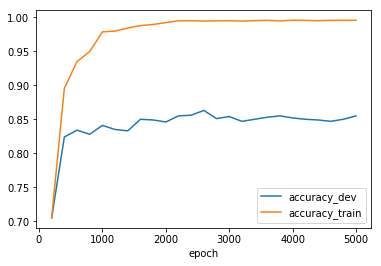

In [10]:
l2_results.iloc[:25].plot()

### L2 results
basically it is uneffective. Are we too overfitted? I think we need something more aggressive.

## Changing the net arch

In [8]:
n_hidden0 = 600
n_hidden1 = 300
n_hidden2 = 200
n_hidden3 = 100

with tf.name_scope("io"):
    X = tf.placeholder(dtype=tf.float32, shape=(None,n_inputs), name="X")
    t = tf.placeholder(dtype=tf.float32, shape=(None,n_outputs), name="t")

regularizer = tf.contrib.layers.l2_regularizer(scale=0.0001)


with tf.name_scope("dnn"):
    acti_fun = tf.nn.elu
    hidden0 = tf.layers.dense(X, n_hidden0, activation=acti_fun, name="hidden0")
    hidden1 = tf.layers.dense(hidden0, n_hidden1, activation=acti_fun, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=acti_fun, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=acti_fun, name="hidden3")
    net_out = tf.layers.dense(hidden3, n_outputs, name="net_out")
    y = tf.nn.softmax(logits=net_out, name="y")
    rounded_y = tf.round(y)

with tf.name_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=t, logits=net_out)
    mean_log_loss = tf.reduce_mean(cross_entropy, name="mean_loss")

#accuracy
correct_predictions = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions,tf.float32))

#optimizer
global_step = tf.Variable(0, trainable=False, name="global_step")
optimizer = tf.train.MomentumOptimizer(learning_rate=0.1, momentum=0.9)
train_step = optimizer.minimize(mean_log_loss, global_step=global_step)
TOT_EPOCS = 5000


Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [9]:
arch_150_100_50_results, _ = run(TOT_EPOCS, "arch_600_300_200_100_results.pickle")

200 Train accuracy:  0.7082 Development accuracy:  0.705
400 Train accuracy:  0.8759 Development accuracy:  0.821
600 Train accuracy:  0.9219 Development accuracy:  0.818
800 Train accuracy:  0.9203 Development accuracy:  0.794
1000 Train accuracy:  0.9626 Development accuracy:  0.827
1200 Train accuracy:  0.9626 Development accuracy:  0.827
1400 Train accuracy:  0.9535 Development accuracy:  0.813
1600 Train accuracy:  0.9685 Development accuracy:  0.824
1800 Train accuracy:  0.9689 Development accuracy:  0.818
2000 Train accuracy:  0.9726 Development accuracy:  0.832
2200 Train accuracy:  0.97 Development accuracy:  0.826
2400 Train accuracy:  0.9661 Development accuracy:  0.815
2600 Train accuracy:  0.9647 Development accuracy:  0.827
2800 Train accuracy:  0.9673 Development accuracy:  0.82
3000 Train accuracy:  0.9652 Development accuracy:  0.831
3200 Train accuracy:  0.9735 Development accuracy:  0.831
3400 Train accuracy:  0.9759 Development accuracy:  0.832
3600 Train accuracy: 

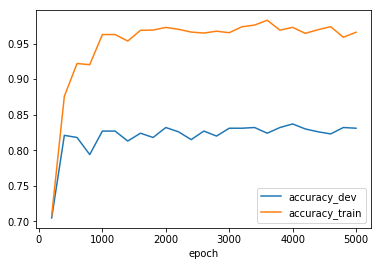

In [10]:
arch_150_100_50_results.plot()

## Dropout

In [7]:
#batch_size = 400

with tf.name_scope("io"):
    X = tf.placeholder(dtype=tf.float32, shape=(None,n_inputs), name="X")
    t = tf.placeholder(dtype=tf.float32, shape=(None,n_outputs), name="t")


training= tf.placeholder_with_default(False, shape=(), name='training')
dropout_rate = 0.5
X_drop = tf.layers.dropout(X, dropout_rate, training=training)



with tf.name_scope("dnn"):
    acti_fun = tf.nn.relu
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=acti_fun, name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=acti_fun, name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    
    hidden3 = tf.layers.dense(hidden2_drop, n_hidden3, activation=acti_fun, name="hidden3")
    hidden3_drop = tf.layers.dropout(hidden3, dropout_rate, training=training)                                  
    net_out = tf.layers.dense(hidden3_drop, n_outputs, name="net_out")
    y = tf.nn.softmax(logits=net_out, name="y")
    rounded_y = tf.round(y)

with tf.name_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=t, logits=net_out)
    mean_log_loss = tf.reduce_mean(cross_entropy, name="mean_loss")

#accuracy
correct_predictions = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions,tf.float32))

#optimizer
global_step = tf.Variable(0, trainable=False, name="global_step")
optimizer = tf.train.MomentumOptimizer(learning_rate=0.1, momentum=0.9)
train_step = optimizer.minimize(mean_log_loss, global_step=global_step)
                                      
def run(n_epochs, save_to=None, initialize = True ):
    if save_to is not None:
        save_to = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")+".pickle"
    if initialize : 
        init = tf.global_variables_initializer()
    with tf.Session() as sess:
        start_time = time()
        various_metrics = []
        sess.run(init)
        for epoch in range (int(n_epochs / epochs_to_display)):
            for iteration in range (epochs_to_display):
                offset = (iteration * epoch * batch_size) % (y_train.shape[0] - batch_size)
                sess.run(train_step, feed_dict={training: True, X: x_train[offset:(offset+batch_size),:],
                                                t: y_train[offset:(offset+batch_size),:]})
            accuracy_train = accuracy.eval(feed_dict={training: False, X: x_train, t: y_train})
            accuracy_dev = accuracy.eval(feed_dict={training: False, X: x_dev, t: y_dev})
            print((epoch+1)*epochs_to_display, "Train accuracy: ", accuracy_train, 
                  "Development accuracy: ", accuracy_dev)
            various_metrics.append({"epoch":(epoch+1)*epochs_to_display, "accuracy_train": accuracy_train, "accuracy_dev" :accuracy_dev})

        accuracy_test = accuracy.eval(feed_dict={X: x_test, t: y_test})
        print ("Test accuracy: ", accuracy_test)
        print ("Target values:\n", y_test[0:10], "\nComputed values:\n", 
               rounded_y.eval(feed_dict={X: x_test[0:10]})) #rounded_y.eval(feed_dict={X: x_test[0:10]}))
        print ("First 10 Predictions: ", 
               correct_predictions.eval(feed_dict={X: x_test[0:10], t: y_test[0:10]}))
        print ("Elapsed time: ", time()-start_time, "secs.")
        to_ret = pd.DataFrame(various_metrics).set_index("epoch")
        print("save_to {}".format(save_to))
        to_ret.to_pickle(save_to)
        return  to_ret, time()-start_time

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [8]:
dropout_05_results, _ = run(15000,save_to="dropout_05_minibatch40_results.pickle")

200 Train accuracy:  0.7916 Development accuracy:  0.775
400 Train accuracy:  0.8487 Development accuracy:  0.825
600 Train accuracy:  0.8658 Development accuracy:  0.836
800 Train accuracy:  0.8737 Development accuracy:  0.832
1000 Train accuracy:  0.8761 Development accuracy:  0.83
1200 Train accuracy:  0.8842 Development accuracy:  0.841
1400 Train accuracy:  0.8861 Development accuracy:  0.843
1600 Train accuracy:  0.8935 Development accuracy:  0.842
1800 Train accuracy:  0.8892 Development accuracy:  0.837
2000 Train accuracy:  0.8963 Development accuracy:  0.842
2200 Train accuracy:  0.9046 Development accuracy:  0.846
2400 Train accuracy:  0.907 Development accuracy:  0.847
2600 Train accuracy:  0.898 Development accuracy:  0.849
2800 Train accuracy:  0.9115 Development accuracy:  0.844
3000 Train accuracy:  0.9161 Development accuracy:  0.851
3200 Train accuracy:  0.912 Development accuracy:  0.847
3400 Train accuracy:  0.9069 Development accuracy:  0.842
3600 Train accuracy:  

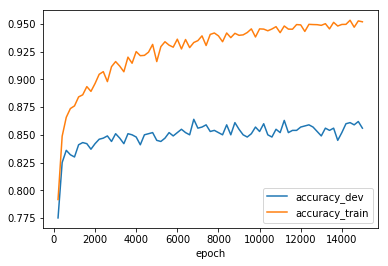

In [14]:
dropout_05_results.iloc[:].plot()

# MiniBatch

In [7]:
batch_size = 400
with tf.name_scope("io"):
    X = tf.placeholder(dtype=tf.float32, shape=(None,n_inputs), name="X")
    t = tf.placeholder(dtype=tf.float32, shape=(None,n_outputs), name="t")


with tf.name_scope("dnn"):
    acti_fun = tf.nn.relu
    hidden1 = tf.layers.dense(X, n_hidden1, activation=acti_fun, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=acti_fun, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=acti_fun, name="hidden3")
    net_out = tf.layers.dense(hidden3, n_outputs, name="net_out")
    y = tf.nn.softmax(logits=net_out, name="y")
    rounded_y = tf.round(y)

with tf.name_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=t, logits=net_out)
    mean_log_loss = tf.reduce_mean(cross_entropy, name="mean_loss")

#accuracy
correct_predictions = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions,tf.float32))

#optimizer
global_step = tf.Variable(0, trainable=False, name="global_step")
optimizer = tf.train.MomentumOptimizer(learning_rate=0.1, momentum=0.9)
train_step = optimizer.minimize(mean_log_loss, global_step=global_step)
TOT_EPOCS = 5000

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [10]:
minibatch_400_results, _ = run(TOT_EPOCS, save_to="minibatch_400.pickle" )

200 Train accuracy:  0.776 Development accuracy:  0.763
400 Train accuracy:  0.9181 Development accuracy:  0.834
600 Train accuracy:  0.9316 Development accuracy:  0.824
800 Train accuracy:  0.9394 Development accuracy:  0.829
1000 Train accuracy:  0.9434 Development accuracy:  0.832
1200 Train accuracy:  0.9783 Development accuracy:  0.828
1400 Train accuracy:  0.9822 Development accuracy:  0.84
1600 Train accuracy:  0.9917 Development accuracy:  0.837
1800 Train accuracy:  0.9908 Development accuracy:  0.831
2000 Train accuracy:  0.9909 Development accuracy:  0.838
2200 Train accuracy:  0.9918 Development accuracy:  0.843
2400 Train accuracy:  0.9921 Development accuracy:  0.837
2600 Train accuracy:  0.9905 Development accuracy:  0.836
2800 Train accuracy:  0.9919 Development accuracy:  0.832
3000 Train accuracy:  0.9926 Development accuracy:  0.833
3200 Train accuracy:  0.992 Development accuracy:  0.832
3400 Train accuracy:  0.9919 Development accuracy:  0.834
3600 Train accuracy: 

# Executing the model

In [24]:
init = tf.global_variables_initializer()

In [7]:
def run(n_epochs, save_to=None, initialize = True ):
    if save_to is None:
        save_to = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")+".pickle"
    if initialize : 
        init = tf.global_variables_initializer()
    with tf.Session() as sess:
        start_time = time()
        various_metrics = []
        sess.run(init)
        for epoch in range (int(n_epochs / epochs_to_display)):
            for iteration in range (epochs_to_display):
                offset = (iteration * epoch * batch_size) % (y_train.shape[0] - batch_size)
                sess.run(train_step, feed_dict={X: x_train[offset:(offset+batch_size),:],
                                                t: y_train[offset:(offset+batch_size),:]})
            accuracy_train = accuracy.eval(feed_dict={X: x_train, t: y_train})
            accuracy_dev = accuracy.eval(feed_dict={X: x_dev, t: y_dev})
            print((epoch+1)*epochs_to_display, "Train accuracy: ", accuracy_train, 
                  "Development accuracy: ", accuracy_dev)
            various_metrics.append({"epoch":(epoch+1)*epochs_to_display, "accuracy_train": accuracy_train, "accuracy_dev" :accuracy_dev})

        accuracy_test = accuracy.eval(feed_dict={X: x_test, t: y_test})
        print ("Test accuracy: ", accuracy_test)
        print ("Target values:\n", y_test[0:10], "\nComputed values:\n", 
               rounded_y.eval(feed_dict={X: x_test[0:10]}))
        print ("First 10 Predictions: ", 
               correct_predictions.eval(feed_dict={X: x_test[0:10], t: y_test[0:10]}))
        print ("Elapsed time: ", time()-start_time, "secs.")
        to_ret = pd.DataFrame(various_metrics).set_index("epoch")
        print("save_to {}".format(save_to))
        to_ret.to_pickle(save_to)
        return  to_ret, time()-start_time

In [14]:
baseline_results, baseline_time = run(10000)

200 Train accuracy:  0.6368 Development accuracy:  0.628
400 Train accuracy:  0.7947 Development accuracy:  0.781
600 Train accuracy:  0.8157 Development accuracy:  0.799
800 Train accuracy:  0.8284 Development accuracy:  0.807
1000 Train accuracy:  0.8349 Development accuracy:  0.818
1200 Train accuracy:  0.8407 Development accuracy:  0.82
1400 Train accuracy:  0.8466 Development accuracy:  0.824
1600 Train accuracy:  0.8488 Development accuracy:  0.82
1800 Train accuracy:  0.8569 Development accuracy:  0.835
2000 Train accuracy:  0.8644 Development accuracy:  0.835
2200 Train accuracy:  0.8679 Development accuracy:  0.832
2400 Train accuracy:  0.872 Development accuracy:  0.834
2600 Train accuracy:  0.8769 Development accuracy:  0.835
2800 Train accuracy:  0.8816 Development accuracy:  0.835
3000 Train accuracy:  0.881 Development accuracy:  0.825
3200 Train accuracy:  0.8901 Development accuracy:  0.831
3400 Train accuracy:  0.8944 Development accuracy:  0.834
3600 Train accuracy:  

In [17]:
pd.to_pickle(baseline_results, "baseline_results.pickle")

In [13]:
baseline_results = pd.read_pickle("baseline_results.pickle")

baseline reuslts are 97% for train accuracy and 82% for development accuracy

time: 65seconds

__Results with respect to one-hidden layer model:__ 

Train: $85\% \rightarrow 97\%$; Development: $81\% \rightarrow 84\%$; Final test: $87\% \rightarrow 90\%$

This deep model involves a total of __600 neurons__ distributed across three hidden layers, __instead of 1,000__ neurons in the just one-hidden layer model.